In [396]:

import os
import numpy as np
import cv2
import math

unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"

data_providers = os.listdir(unipen_root)

for data_provider in data_providers:
    print(f"Looking at provider {data_provider}")
    data_provider_path = os.path.join(unipen_root, data_provider)
    data_path = os.path.join(data_provider_path, "data")

    if not os.path.exists(data_path):
        print(f"Data provider {data_provider} without data")
        continue

    doc_files = [filename for filename in os.listdir(data_provider_path) if filename != "data"]
    print(f"Doc files: {doc_files}")
    print(f"Stroke files: {os.listdir(data_path)}")
    

Looking at provider abm
Doc files: ['abm0.doc']
Stroke files: ['ca0.dat', 'ibo0.dat', 'sm0.dat', 'wz0.dat']
Looking at provider aga
Doc files: []
Stroke files: ['amywldrp.dat', 'annzchrl.dat', 'crlmtchl.dat', 'dawnmrsh.dat', 'drdvlllb.dat', 'elsbthey.dat', 'greghunt.dat', 'jamesmor.dat', 'jhnshrly.dat', 'lzbthwht.dat', 'mlssdrry.dat', 'nikkshmn.dat', 'scttjyns.dat', 'shrncrtr.dat']
Looking at provider anj
Doc files: ['anj.doc', 'anj.lex']
Stroke files: ['g9303.dat', 'g9304.dat', 'g9312.dat', 'g9313.dat', 'g9314.dat', 'g9318.dat']
Looking at provider apa
Doc files: ['app.doc']
Stroke files: ['apa00', 'apa01', 'apa02', 'apa03', 'apa04', 'apa09', 'apa10', 'apa12', 'apa13', 'apa14', 'apa15', 'apa16', 'apa19', 'apa20']
Looking at provider apb
Doc files: ['app.doc']
Stroke files: ['apb02', 'apb04', 'apb05', 'apb06', 'apb07', 'apb08', 'apb09', 'apb10', 'apb12', 'apb13', 'apb14', 'apb15', 'apb16', 'apb17', 'apb18', 'apb20', 'apb21', 'apb22', 'apb23', 'apb24', 'apb25', 'apb27', 'apb28', 'apb29'

In [397]:
from enum import Enum
class UnipenKeywords(Enum):
    # Config-related
    X_DIM = "X_DIM"
    Y_DIM = "Y_DIM"
    X_POINTS_PER_INCH = "X_POINTS_PER_INCH"
    Y_POINTS_PER_INCH = "Y_POINTS_PER_INCH"
    X_POINTS_PER_MM = "X_POINTS_PER_MM"
    Y_POINTS_PER_MM = "Y_POINTS_PER_MM"

    POINTS_PER_SECOND = "POINTS_PER_SECOND"
    COORD = "COORD"

    # Stroke-related
    PEN_UP = "PEN_UP"
    PEN_DOWN = "PEN_DOWN"
    START_BOX = "START_BOX"

In [398]:
import re

class UnipenHandler():
    handler_root: str
    strokes: list[list[int, int, bool]]

    COMMAND_PATTERN = r"^\.(\w*) ?(.*)$"

    def __init__(self, handler_root: str):
        self.handler_root = handler_root
        self.strokes = []

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files.
        The specific handler prepare its config there"""
        raise NotImplementedError

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Get the configuration for the given data file. Specific to handler type."""
        raise NotImplementedError
    
    def search_values_in_file(self, filepath: str, search_keys: set[str], throw_on_missing: bool) -> dict:
        """Helper function.
        Search the given values inside of the file. Return every match in a dictionnary
        The function will either return empty values for missing keys, or throw an exception"""
        result_dict = {}
        found_keys = set()
        
        with open(filepath, "rt") as f:

            for line in f.readlines():
                command_match = re.match(UnipenHandler.COMMAND_PATTERN, line)
                if command_match:
                    if command_match.group(1) in search_keys:
                        key = command_match.group(1)
                        values = command_match.group(2).strip()
                        if " " in values:
                            values = values.split(" ")
                        found_keys.add(key)
                        try:
                            result_dict[key].extend(values)
                        except KeyError:
                            result_dict[key] = values if isinstance(values, list) else [values]

                #Early termination: 
                set_diff = search_keys-found_keys
                if len(set_diff) == 0:
                    break
        
        set_diff = search_keys-found_keys
        if len(set_diff) > 0:
            error = f"Missing key values {set_diff} on file {filepath}"
            if throw_on_missing:
                raise Exception(error)
            else:
                print(error)
        
        return result_dict

    def create_strokes(self): 
        """In single doc format, we can open the 'data' folder and expect files to be strokes / folder of files"""
        data_folder = os.path.join(self.handler_root, "data")
        self.scan_data_folder(data_folder)
    
    def scan_data_folder(self, data_folder: str):
        """Scan a data folder in search of stroke files. In case of nested folder, scan nested folders"""
        print(f"Scanning {data_folder}")
        for filename in os.listdir(data_folder):
            filepath = os.path.join(data_folder, filename)
            if os.path.isdir(filepath):
                self.scan_data_folder(filepath)
            elif os.path.isfile(filepath):
                strokes = self.read_stroke_file(filepath)
                self.strokes.extend(strokes)

    def end_stroke(self, stroke: list, config: dict) -> list:
        """End a stroke and register if it is not empty.
        Return an empty stroke: Either the empty stroke in input or a new empty array"""
        if len(stroke) > 0:
            processed_stroke = self.process_stroke(np.array(stroke), config)
            self.strokes.append(processed_stroke)
            return []
        else:
            return stroke

    def read_stroke_file(self, filepath: str) -> list[tuple[int, int, bool]]:
        """Read a stroke file and return the list as a (x, y, penUp) signal"""
        configuration = self.get_config_for_datafile(filepath)
        coord_config: list = configuration[UnipenKeywords.COORD.value]

        idx, idy = coord_config.index("X"), coord_config.index("Y")

        #Read the line iteratively, line by line. Check if line is an instruction (.INSTRUCTION). If not, try to retrieve coordinates.
        strokes = []
        with open(filepath, "rt") as f:
            #Start at the first PEN instruction
            is_started = False
            pen_down = False
            current_stroke = []
            for line in f:
                line = line.rstrip().strip()
                
                #Gap
                if is_started and not line:
                    current_stroke = self.end_stroke(current_stroke, configuration)
                    continue

                command_match = re.match(UnipenHandler.COMMAND_PATTERN, line)
                if command_match:
                    match command_match.group(1):
                        #the penup signal is encoded in the last value of the stroke
                        case UnipenKeywords.PEN_UP.value:
                            is_started = True
                            pen_down = False
                            if len(current_stroke) > 0:
                                current_stroke[-1][2] = True
                        case UnipenKeywords.PEN_DOWN.value:
                            is_started = True
                            pen_down = True
                            #Well, some providers (anj) put a pen down WITHOUT a pen up, so we have to add the penup signal anyway.
                            if len(current_stroke) > 0:
                                current_stroke[-1][2] = True
                        case _:
                            continue
                else:
                    if not is_started or line.startswith("#"):
                        continue
                    
                    # Not empty line and not command: Assume coordinate line.
                    coords = line.strip().split()

                    x, y = int(coords[idx]), int(coords[idy])
                    if x==0 and y==0:
                        current_stroke = self.end_stroke(current_stroke, configuration)
                    else:
                        # Register points if and only if pen is down.
                        if pen_down:
                            current_stroke.append([x, y, False])

        #Add last current stroke
        self.end_stroke(current_stroke, configuration)

        return strokes

    def resample_by_interpolation(self, signal, input_fs, output_fs):
        """Re-sampling using scypi linear interpolation
        credit to: https://stackoverflow.com/questions/51420923/resampling-a-signal-with-scipy-signal-resample
        Additional credits
        DISCLAIMER: This function is copied from https://github.com/nwhitehead/swmixer/blob/master/swmixer.py, 
        which was released under LGPL. 
        """

        scale = output_fs / input_fs
        # calculate new length of sample. Keep minimum of 1 point
        n = max(round(len(signal) * scale), 1)

        # use linear interpolation
        # endpoint keyword means than linspace doesn't go all the way to 1.0
        # If it did, there are some off-by-one errors
        # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
        # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
        # Both are OK, but since resampling will often involve
        # exact ratios (i.e. for 44100 to 22050 or vice versa)
        # using endpoint=False gets less noise in the resampled sound
        resampled_signal = np.interp(
            np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
            np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
            signal,  # known data points
        )
        return resampled_signal

    def resample_stroke(self, stroke: np.ndarray, in_scale: int, out_scale: int) -> np.ndarray:
        """Resample a stroke by resampling every sub-stroke, thus respecting the penup signals"""

        #Cut the signal into sub-signal separated by the penup instruction
        substrokes = []
        current_substroke = []

        for (x, y, penup) in stroke:
            current_substroke.append([x, y])
            if penup:
                substrokes.append(np.array(current_substroke))
                current_substroke = []

        if len(current_substroke) > 0:
            substrokes.append(np.array(current_substroke))
            
        #Resample x,y values
        resampled_substrokes = []
        for substroke in substrokes:
            print(f"Substroke: {substroke.shape}, in: {in_scale}, out: {out_scale}")
            x_resampled = np.rint(self.resample_by_interpolation(substroke[:, 0], in_scale, out_scale)).astype(int)
            y_resampled = np.rint(self.resample_by_interpolation(substroke[:, 1], in_scale, out_scale)).astype(int)
            print(f"x_resample size: {x_resampled.shape}")
            penup_resampled = np.full_like(x_resampled, fill_value=False)
            penup_resampled[-1] = True

            resampled_substroke = np.concatenate(
                (x_resampled[:, np.newaxis], y_resampled[:, np.newaxis], penup_resampled[:, np.newaxis]), 
                axis=1
            )

            resampled_substrokes.append(resampled_substroke)

        #Re-construct the stroke
        final_stroke = np.concatenate(resampled_substrokes, axis=0, dtype=np.int32)
        return final_stroke

    def process_stroke(self, stroke: list[tuple[int, int, bool]], config: dict):
        """Apply post processing to the strokes
        Config: Configuration of the stroke, especially containing spatial info (DPI, PPI, etc) and spatial info (Points per seconds)"""
        align_strokes = True
        start_padding = 5

        #Y axis is inversed between plotting and signal
        max_y = max(stroke[:, 1])
        stroke[:, 1] = max_y - stroke[:, 1]

        #Alignement / padding
        if align_strokes:
            min_x = min(stroke[:, 0])
            stroke[:, 0] -= (min_x - start_padding)

            min_y = min(stroke[:, 1])
            stroke[:, 1] -= (min_y - start_padding)

        #TODO
        # Frequency adjustment
        signal_freq = int(config[UnipenKeywords.POINTS_PER_SECOND.value][0])
        target_pps = 100 #100PPS, or 10MS
        if signal_freq != target_pps:
            stroke = self.resample_stroke(stroke, signal_freq, target_pps)

        #TODO
        #Pix distance adjustment
        # X_POINTS_PER_INCH = "X_POINTS_PER_INCH"
        # Y_POINTS_PER_INCH = "Y_POINTS_PER_INCH"
        # X_POINTS_PER_MM = "X_POINTS_PER_MM"
        # Y_POINTS_PER_MM = "Y_POINTS_PER_MM"

        return stroke

In [399]:
import re

class SingleDocFileHandler(UnipenHandler):
    """This handler manages Unipen provider with a single data file and a data/ folder containing strokes.
    If a or multiple lex file exist, ignore them"""
    config: dict

    def __init__(self, handler_root: str):
        super().__init__(handler_root)

        self.process_doc()

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files"""
        #Retrieve single doc file
        files = os.listdir(self.handler_root)
        doc_candidates = [file for file in files if file.endswith(".doc")]
        if len(doc_candidates) != 1:
            raise Exception(f"Provider {self.handler_root}: Expected one doc file, found {doc_candidates}")

        doc_file = doc_candidates[0]

        #Parse doc file in order to find the data required to interpret the stroke
        required_search_values = set([UnipenKeywords.POINTS_PER_SECOND.value, UnipenKeywords.COORD.value])
        opt_search_values = set([
            UnipenKeywords.X_DIM.value, UnipenKeywords.Y_DIM.value,
            UnipenKeywords.X_POINTS_PER_INCH.value, UnipenKeywords.Y_POINTS_PER_INCH.value, 
            UnipenKeywords.X_POINTS_PER_MM.value, UnipenKeywords.Y_POINTS_PER_MM.value, 
        ])

        doc_filepath = os.path.join(self.handler_root, doc_file)
        self.config = {}
        self.config.update(self.search_values_in_file(doc_filepath, required_search_values, throw_on_missing=True))
        self.config.update(self.search_values_in_file(doc_filepath, opt_search_values, throw_on_missing=False))
        

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Simple: In single doc mode the configuration is always the same"""
        return self.config

In [400]:
from pathlib import Path

class MultiDocFileHandler(UnipenHandler):
    """This handler manages Unipen provider with multiple doc files and a data/ folder containing strokes.
    It parses every config file and assumes that the data folder will be related to the doc files.
    If a or multiple lex file exist, ignore them"""
    configs: dict
    
    def __init__(self, handler_root: str):
        super().__init__(handler_root)

        self.process_doc()

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files"""
        files = os.listdir(self.handler_root)
        doc_files = [file for file in files if file.endswith(".doc")]

        self.configs = {}

        for doc_file in doc_files:
            #Parse doc file in order to find the data required to interpret the stroke
            required_search_values = set([UnipenKeywords.POINTS_PER_SECOND.value, UnipenKeywords.COORD.value])
            opt_search_values = set([
                UnipenKeywords.X_DIM.value, UnipenKeywords.Y_DIM.value,
                UnipenKeywords.X_POINTS_PER_INCH.value, UnipenKeywords.Y_POINTS_PER_INCH.value, 
                UnipenKeywords.X_POINTS_PER_MM.value, UnipenKeywords.Y_POINTS_PER_MM.value, 
            ])

            doc_filepath = os.path.join(self.handler_root, doc_file)

            config_file = {}
            
            config_file.update(self.search_values_in_file(doc_filepath, required_search_values, throw_on_missing=True))
            config_file.update(self.search_values_in_file(doc_filepath, opt_search_values, throw_on_missing=False))
            doc_file_key = Path(doc_file).stem
            # some providers have header_{folder}.doc files, it is very easy to remove the header part
            if "header_" in doc_file_key:
                doc_file_key = doc_file_key.removeprefix("header_")
            print(f"Create config {doc_file_key}")
            self.configs[doc_file_key] = config_file

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Return the doc file corresponding to the data folder of the data file."""
        data_path = Path(datafile_path)
        data_folder = data_path.parent.name
        try:
            print(f"Requesting config for {datafile_path}, searching key {data_folder}")
            return self.configs[data_folder]
        except KeyError:
            doc_name = data_path.stem
            #For TOS: TOS does not consider the folder to have the same name as the doc file, but a 1;1 datafile - docfile
            print(f"Requesting config for {datafile_path}, searching key {doc_name}")
            return self.configs[doc_name]

In [401]:
from pathlib import Path

class NoDocFileHandler(UnipenHandler):
    """This handler manages Unipen provider with no doc files and a data/ folder containing strokes.
    In this configuration, it is assumed that each data file must contain the documentation at its start. As the search in file function returns
    when values are found, it means minimal overhead (2IO operations instead of 1)
    If a or multiple lex file exist, ignore them"""
    configs: dict
    
    def __init__(self, handler_root: str):
        super().__init__(handler_root)

        self.process_doc()

    def process_doc(self):
        """Process the documentation of this Unipen handler, assuming the data files are the documentation"""
        data_path = os.path.join(self.handler_root, "data")
        files = os.listdir(data_path)

        self.configs = {}

        for file in files:
            #Parse doc file in order to find the data required to interpret the stroke
            required_search_values = set([UnipenKeywords.POINTS_PER_SECOND.value, UnipenKeywords.COORD.value])
            opt_search_values = set([
                UnipenKeywords.X_DIM.value, UnipenKeywords.Y_DIM.value,
                UnipenKeywords.X_POINTS_PER_INCH.value, UnipenKeywords.Y_POINTS_PER_INCH.value, 
                UnipenKeywords.X_POINTS_PER_MM.value, UnipenKeywords.Y_POINTS_PER_MM.value, 
            ])

            doc_filepath = os.path.join(data_path, file)
            if os.path.isdir(doc_filepath):
                child_files = [os.path.join(file, child_file) for child_file in os.listdir(doc_filepath)]
                files.extend(child_files)
                continue

            config_file = {}
            
            config_file.update(self.search_values_in_file(doc_filepath, required_search_values, throw_on_missing=True))
            config_file.update(self.search_values_in_file(doc_filepath, opt_search_values, throw_on_missing=False))
            doc_file_key = Path(doc_filepath).stem
            # some providers have header_{folder}.doc files, it is very easy to remove the header part
            if "header_" in doc_file_key:
                doc_file_key = doc_file_key.removeprefix("header_")
            print(f"Create config {doc_file_key}")
            self.configs[doc_file_key] = config_file

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Return the doc file corresponding to the data folder of the data file."""
        doc_file_key = Path(datafile_path).stem
        print(f"Requesting config for {datafile_path}, searching key {doc_file_key}")
        return self.configs[doc_file_key]


In [402]:
import os

class UnipenHandlerBuilder():
    """This class holds the knowledge of the UNIPEN data providers and their different formats.
    It can be used to build the different online signals through builders adapted to providers."""
    unipen_root: str

    provider_type_mapping = {
        SingleDocFileHandler: [
                                "abm", "anj", "apa", "apb", "apc", "apd", "ape", "app", "att", 
                               "bba", "bbb", "bbc", "bbd", 
                               "cea", "ceb", "cec", "ced", "cee",
                               "dar", "gmd", "imt", "int", 
                               "lex", "par", "pcl", "pri",
                               "rim", "scr", "uqb"
                            ],

        # MultiDocFileHandler: [
        #                         "hpb", "hpp", "huj", "tos",
        #                         "kai", "kar", "lav", "lou", 
        #                         "mot", "pap", "phi", "sta", 
        #                         "syn", "val", "ugi"
        #                     ],
                            
        # NoDocFileHandler: [
        #                         "art", "aga", "atu", "nic", 
        #                         "sie"
        #                     ],
        # Problems
        #   Empty: ata, cef, ibm, imp
        #   No temporal info: not

        #Par: .inc file changed to .doc and COORD added to it, as every stroke file has the same COORD system. Avoids creating a single handler for this one.
        #PCL: Rename internal_pad.doc to .doc.other as it has the same information as the pcl.doc file.
        #phi: Renaned *file* to *file*.doc
        #HPP: rename hpp doc files form hpb* into hpp*
        #HUJ: Put manudo datafile into huj8/ folder in order to have corresponding doc file
        #STA: rename hpb{0,1}.doc to sta{0,1}.doc
        #Val: Separate two writers into val01, val02 folders to correspond to expected structure
    }

    def __init__(self, unipen_root: str) -> None:
        self.unipen_root = unipen_root

    def build_handlers(self) -> list[UnipenHandler]:
        """Build all the handlers declared by this provider maping"""
        provider_return: list[UnipenHandler] = []
        
        for handler_class, providers in self.provider_type_mapping.items():
            print(f"Len of providers: {len(providers)}")
            for provider in providers:
                try:
                    print(f"Building provider {provider} as {handler_class.__name__}")
                    provider_path = os.path.join(self.unipen_root, provider)
                    provider_handler = handler_class(provider_path)
                    provider_return.append(provider_handler)
                except Exception as e:
                    print(f"Impossible to build provider {provider} due to error: {e}")
                    raise e

        return provider_return

In [403]:
unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"

unipen_handler_builder = UnipenHandlerBuilder(unipen_root)
handlers = unipen_handler_builder.build_handlers()

print(f"built {len(handlers)} handlers")

Len of providers: 29
Building provider abm as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/abm/abm0.doc
Building provider anj as SingleDocFileHandler
Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/anj/anj.doc
Building provider apa as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/apa/app.doc
Building provider apb as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/apb/app.doc
Building provider apc as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/apc/app.doc
Building provider apd as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS

Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/ceb/ced1.doc
Building provider cec as SingleDocFileHandler
Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/cec/ced2.doc
Building provider ced as SingleDocFileHandler
Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/ced/ced3.doc
Building provider cee as SingleDocFileHandler
Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/cee/ced4.doc
Building provider dar as SingleDocFileHandler
Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/dar/dar2.doc
Building provider gmd as SingleDocFileHandler
Missing key values {'X_DIM', 'Y_DIM', 'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/

In [404]:
stroke_lengths = []
for handler in handlers:
    handler.create_strokes()
    stroke_lengths.append(len(handler.strokes))
    
print(f"Total strokes: {sum(stroke_lengths)}, repartition: {stroke_lengths}")

Scanning ../../data/handwriting/Unipen/train_r01_v07/include/abm/data
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/anj/data
Substroke: (392, 2), in: 200, out: 100
x_resample size: (196,)
Substroke: (370, 2), in: 200, out: 100
x_resample size: (185,)
Substroke: (409, 2), in: 200, out: 100
x_resample size: (204,)
Substroke: (378, 2), in: 200, out: 100
x_resample size: (189,)
Substroke: (426, 2), in: 200, out: 100
x_resample size: (213,)
Substroke: (343, 2), in: 200, out: 100
x_resample size: (172,)
Substroke: (353, 2), in: 200, out: 100
x_resample size: (176,)
Substroke: (420, 2), in: 200, out: 100
x_resample size: (210,)
Substroke: (422, 2), in: 200, out: 100
x_resample size: (211,)
Substroke: (785, 2), in: 200, out: 100
x_resample size: (392,)
Substroke: (776, 2), in: 200, out: 100
x_resample size: (388,)
Substroke: (777, 2), in: 200, out: 100
x_resample size: (388,)
Substroke: (762, 2), in: 200, out: 100
x_resample size: (381,)
Substroke: (841, 2), in: 200, out: 100
x_

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
import numpy as np

DRAW_COLOR_BLACK = 255
DRAW_COLOR_WHITE = 0

def create_image(signal: list[int, int, bool], draw_color = 1):
    """Create the image associated with the given signal."""
    max_h =  int(math.ceil(max(signal[:, 0])))
    max_w = int(math.ceil(max(signal[:, 1])))

    canvas = np.ascontiguousarray(np.full((max_w + 2, max_h + 2), DRAW_COLOR_BLACK), dtype=np.uint8)
    print(f"Canvas: {canvas.shape}")
    
    #Draw lines from point (t-1) to current point (t) IFF the pen was not up. start with penup
    #as we start from point 0.
    draw_current_stroke = False
    for x, y, eos in signal:
        if draw_current_stroke:
            cv2.line(canvas, (last_x, last_y), (x, y), DRAW_COLOR_WHITE, draw_color) 
        last_x, last_y, draw_current_stroke = x, y, not eos
    
    return canvas

In [ ]:
def compute_reasonable_stroke_size(stroke: np.ndarray):
    return 1 + int(max(stroke[:, 1]) / 80)

Handler 0: ../../data/handwriting/Unipen/train_r01_v07/include/pri
(34, 3)
Canvas: (261, 159)
(26, 3)
Canvas: (171, 101)
(39, 3)
Canvas: (326, 150)


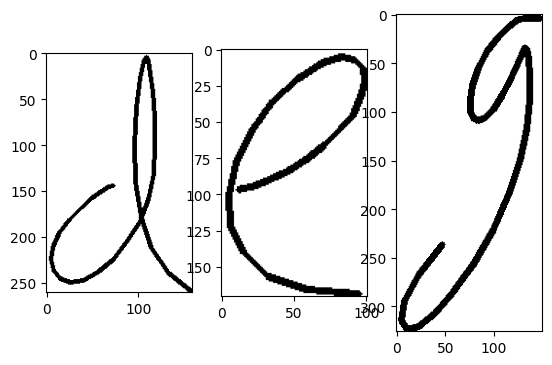

In [ ]:
import matplotlib.pyplot as plt
from random import randint

for i, handler in enumerate(handlers):
    print(f"Handler {i}: {handler.handler_root}")
    strokes = handler.strokes

    n = randint(0, len(strokes) - 3)

    fig, axs = plt.subplots(1, 3)

    for i, stroke in enumerate(strokes[n:n+3]):
        print(stroke.shape)
        
        image = create_image(stroke, compute_reasonable_stroke_size(stroke))

        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

Testing problematic providers

In [ ]:
unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"
provider = "ced"

handler = SingleDocFileHandler(os.path.join(unipen_root, provider))
handler.create_strokes()
print(f"Strokes: {len(handler.strokes)}")

import matplotlib.pyplot as plt
from random import randint

strokes = handler.strokes

n = randint(0, len(strokes) - 4)

fig, axs = plt.subplots(1, 3)

for i, stroke in enumerate(strokes[n:n+3]):
    print(stroke.shape)
    image = create_image(stroke, compute_reasonable_stroke_size(stroke))

    axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()

Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/ced/ced3.doc
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/ced/data
Building final stroke from [(18, 3), (2, 3), (8, 3), (6, 3), (22, 3), (22, 3), (28, 3)]
Final length: 106, shape: (106, 3)
Building final stroke from [(28, 3), (18, 3), (10, 3), (4, 3), (22, 3), (20, 3), (22, 3), (14, 3), (7, 3), (19, 3), (32, 3), (14, 3), (14, 3), (16, 3), (22, 3), (16, 3), (6, 3), (14, 3), (22, 3)]
Final length: 320, shape: (320, 3)
Building final stroke from [(32, 3), (8, 3), (5, 3), (16, 3), (4, 3), (16, 3), (5, 3), (16, 3), (16, 3), (6, 3), (30, 3), (17, 3), (14, 3), (6, 3), (16, 3), (5, 3), (14, 3), (18, 3)]
Final length: 244, shape: (244, 3)
Building final stroke from [(32, 3), (16, 3), (10, 3), (4, 3), (25, 3), (24, 3), (14, 3), (25, 3)]
Final length: 150, shape: (150, 3)
Building final stroke from [(24, 3), (5, 3), (9, 3), (7, 3), (31, 3), (18, 3), (28, 3), (

IndexError: index -1 is out of bounds for axis 0 with size 0